In [89]:
import numpy as np
import pandas as pd 
from xgboost import XGBRegressor 
from sklearn.model_selection import TimeSeriesSplit
import warnings              
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
from sklearn.preprocessing import StandardScaler
from itertools import product                   
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize         
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [90]:
train = pd.read_csv("ts_train.csv")
test = pd.read_csv("ts_test.csv")
test['ACTUAL'] = 0
results_hwm = pd.read_csv("prim5.csv")
res = np.array(results_hwm.value)
test.ACTUAL = np.array(res)
train.Date = train.Date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
test.Date = test.Date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
train['cold'] = train.Temp.apply(lambda x: 10 if x >= 5 else 100)
train['hot'] = train.Temp.apply(lambda x: 100 if x >= 25 else 10)
test['cold'] = test.Temp.apply(lambda x: 10 if x >= 5 else 100)
test['hot'] = test.Temp.apply(lambda x: 100 if x >= 25 else 10)
for val in (train, test):
    val['year']=val.Date.dt.year 
    val['month']=val.Date.dt.month 
    val['day']=val.Date.dt.day

In [91]:
def select_ts(index):
    return (train[train.tsID == index].copy(),
            test[test.tsID == index].copy())

In [92]:
def featurize(i):
    train, test = select_ts(i)
    exog_train = train
    exog_train['sin1'] = np.sin(2 * np.pi * exog_train.ID)
    exog_train['cos1'] = np.cos(2 * np.pi * exog_train.ID)
    exog_train['temp_sin'] = np.sin(2 * np.pi * exog_train.Temp)
    exog_train['temp_cos'] = np.cos(2 * np.pi * exog_train.Temp)
    exog_train['temp3'] = exog_train.Temp.apply(lambda x: x**3)
    exog_train['temp_sin3'] = np.sin(2 * np.pi * exog_train.temp3)
    exog_train['temp_cos3'] = np.cos(2 * np.pi * exog_train.temp3)
    exog_train['temp5'] = exog_train.Temp.apply(lambda x: x**5)
    exog_train['temp_sin5'] = np.sin(2 * np.pi * exog_train.temp5)
    exog_train['temp_cos5'] = np.cos(2 * np.pi * exog_train.temp5)
    exog_train['temp7'] = exog_train.Temp.apply(lambda x: x**7)
    exog_train['temp_sin7'] = np.sin(2 * np.pi * exog_train.temp7)
    exog_train['temp_cos7'] = np.cos(2 * np.pi * exog_train.temp7)
    exog_train['temp9'] = exog_train.Temp.apply(lambda x: x**9)
    exog_train['temp_sin9'] = np.sin(2 * np.pi * exog_train.temp9)
    exog_train['temp_cos9'] = np.cos(2 * np.pi * exog_train.temp9)
    exog_train['res'] = exog_train.ACTUAL.apply(lambda x: x)
    exog_train['res2'] = exog_train.ACTUAL.apply(lambda x: x**2)
    exog_train['ressin'] = np.sin(2 * np.pi * exog_train.ACTUAL)
    exog_train['rescos'] = np.cos(2 * np.pi * exog_train.ACTUAL)

    exog_test = test
    exog_test['sin1'] = np.sin(2 * np.pi * exog_test.Temp)
    exog_test['cos1'] = np.sin(2 * np.pi * exog_test.Temp)
    exog_test['temp_sin'] = np.sin(2 * np.pi * exog_test.Temp)
    exog_test['temp_cos'] = np.cos(2 * np.pi * exog_test.Temp)
    exog_test['temp3'] = exog_test.Temp.apply(lambda x: x**3)
    exog_test['temp_sin3'] = np.sin(2 * np.pi * exog_test.temp3)
    exog_test['temp_cos3'] = np.cos(2 * np.pi * exog_test.temp3)
    exog_test['temp5'] = exog_test.Temp.apply(lambda x: x**5)
    exog_test['temp_sin5'] = np.sin(2 * np.pi * exog_test.temp5)
    exog_test['temp_cos5'] = np.cos(2 * np.pi * exog_test.temp5)
    exog_test['temp7'] = exog_test.Temp.apply(lambda x: x**7)
    exog_test['temp_sin7'] = np.sin(2 * np.pi * exog_test.temp7)
    exog_test['temp_cos7'] = np.cos(2 * np.pi * exog_test.temp7)
    exog_test['temp9'] = exog_test.Temp.apply(lambda x: x**9)
    exog_test['temp_sin9'] = np.sin(2 * np.pi * exog_test.temp9)
    exog_test['temp_cos9'] = np.cos(2 * np.pi * exog_test.temp9)
    exog_test['res'] = exog_test.ACTUAL.apply(lambda x: x)
    exog_test['res2'] = exog_test.ACTUAL.apply(lambda x: x**2)
    exog_test['ressin'] = np.sin(2 * np.pi * exog_test.ACTUAL)
    exog_test['rescos'] = np.cos(2 * np.pi * exog_test.ACTUAL)
    
    train_f = exog_train.drop(['Date', 'ID'],axis = 1).dropna()
    test_f = exog_test.drop(['Date', 'ID'],axis = 1).dropna()
    return (train_f, test_f)

In [93]:
def test_train_split(i):
    train, test = featurize(i)
    #make a huge mess, given old predictions
    merge_train = train.append(test, ignore_index =True)
    m = int(merge_train.shape[0]/5)
    merge_train_f = merge_train[:-m]

    test = merge_train[-300:].dropna().drop(['ACTUAL'], axis=1)
    n = int(merge_train.shape[0]/3)
    
    x_train = merge_train_f.iloc[:n].dropna().drop(['ACTUAL'], axis=1)
    x_test = merge_train_f.iloc[n:].dropna().drop(['ACTUAL'], axis=1)
    y_train = merge_train_f.ACTUAL.iloc[:n]
    y_test = merge_train_f.ACTUAL.iloc[n:]
    return (x_train, x_test, y_train, y_test, test)

In [94]:
def main(i):
    train_i, test_i = select_ts(i)
    x_train, x_test, y_train, y_test, test_f =test_train_split(i)
    reg = XGBRegressor(n_estimators=1000, booster = 'dart')
    reg.fit(x_train, y_train,
            eval_set=[(x_train, y_train), (x_test, y_test)],
            early_stopping_rounds=269, 
            verbose=False)
    
    
    plt.plot(train_i.ID, train_i.ACTUAL)
    plt.plot(pd.Series(reg.predict(test_f), index = test_i.ID))
    reg_res = reg.predict(test_f)
    df = pd.Series(reg_res, index = test_i.ID)
    return df

[03:22:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:22:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:23:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:24:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:24:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

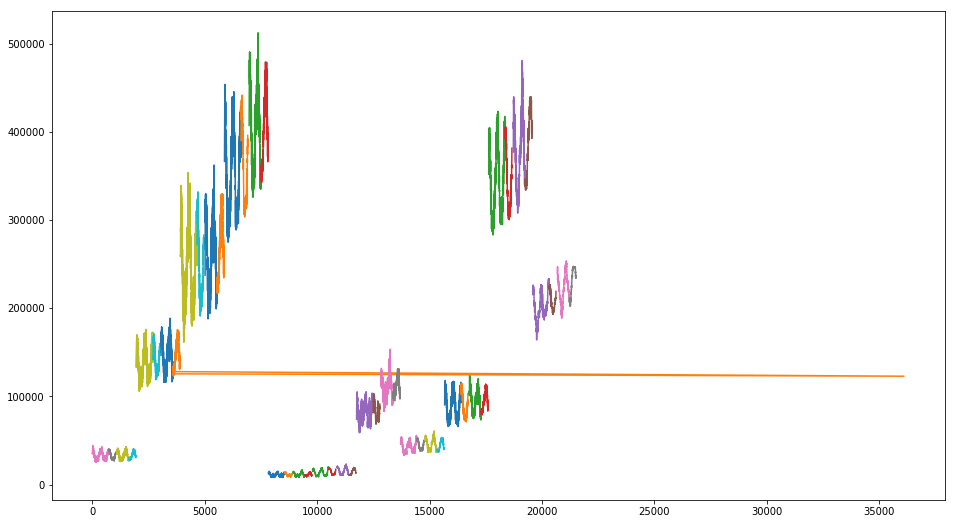

In [95]:
test_final = None
for i in range(1, 23):
    if i == 1:
        test_final = main(1)
    else:
        test_final = test_final.append(main(i))

In [97]:
test_final.to_csv("hwm_xgb_3.csv")

use statsmodels api smoother 

In [83]:
def main_sarimax(i):
    train_i, test_i = select_ts(i)
    x_train, x_test, y_train, y_test, test_f =test_train_split(i)
    x_fin = x_train.append(x_test)[:735]
    y_fin = y_train.append(y_test)[:735]
    model = SARIMAX(endog = y_fin, exog=x_fin, order=(7,1,7),seasonal_order=(7,1,7,1), 
                    enforce_invertibility=False, enforce_stationarity=False)
    fit2 = model.fit()
    pred = fit2.predict(exog = test_f)[:300]
    
    plt.plot(test_i.ID, pred)
    plt.plot(train_i.ID, train_i.ACTUAL)

    df = pd.Series(np.array(pred), index = test_i.ID)
    return df

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


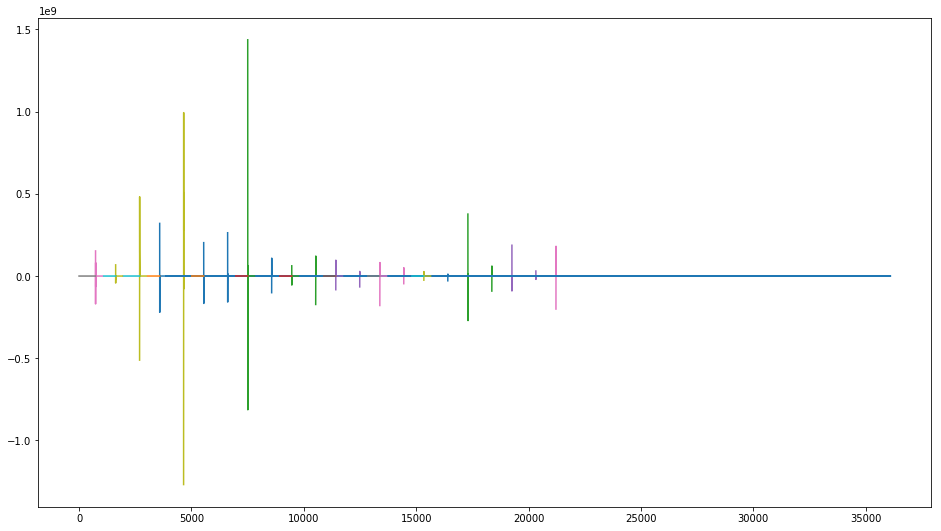

In [85]:
test_final = None
for i in range(1, 23):
    if i == 1:
        print(i)
        test_final = main_sarimax(1)
    else:
        print(i)
        test_final = test_final.append(main_sarimax(i))

In [86]:
test_final.to_csv("sarimax2.csv")

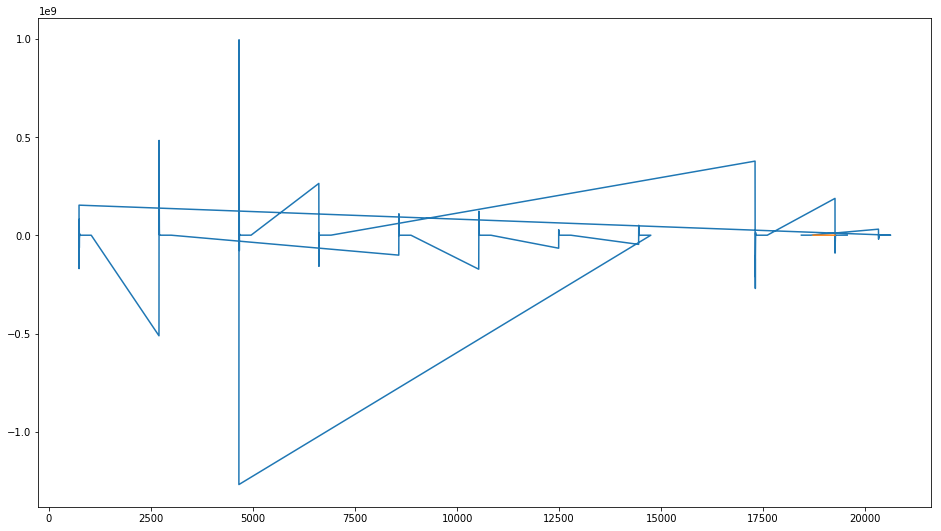

In [88]:
plt.plot(test_final[370:3900])
train1, test1 = select_ts(13)
plt.plot(train1.ID, train1.ACTUAL)